In [15]:
import numpy as np
import pandas as pd
import os
import shutil
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
arabic_characters = np.array(sorted(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ','ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع','غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']))
arabic_characters

array(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش',
       'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه',
       'و', 'ى'], dtype='<U1')

In [3]:
# Data directory : In case we used google drive to train on colab
# from google.colab import drive
# drive.mount("/content/drive")
# DATA_DIR = '/content/drive/My Drive/OCR_Task/'

# Data directory : In case we trained local
DATA_DIR = 'data/'

In [4]:
train_df = pd.read_csv(DATA_DIR + "train.csv")
test_df  = pd.read_csv(DATA_DIR + "test.csv")

train_df.head()

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19


### Creating dirctories containing labeled train images

In [5]:
if not os.path.isdir(os.path.join(DATA_DIR, 'train_labeled/')):
    os.mkdir(DATA_DIR + 'train_labeled/')
    
for _, row in train_df.iterrows():
    id = row['id']
    l = row['label']
    
    if not os.path.isdir(os.path.join(DATA_DIR, 'train_labeled/{}/'.format(arabic_characters[l-1]))):
        os.mkdir(os.path.join(DATA_DIR, 'train_labeled/{}/'.format(arabic_characters[l-1])))
        
    shutil.copy(DATA_DIR+'train/{:05d}.png'.format(id), DATA_DIR+'train_labeled/{}/'.format(arabic_characters[l-1]))

# Create train data generator

In [6]:
BATCH_SIZE = 32
train_dir = os.path.join(DATA_DIR, 'train_labeled/')

datagen = ImageDataGenerator(validation_split=0.2)

train_gen = datagen.flow_from_directory(train_dir,
                                        batch_size=BATCH_SIZE,
                                        target_size=(32, 32),
                                        subset='training')

val_gen = datagen.flow_from_directory(train_dir,                                    
                                      batch_size=BATCH_SIZE,
                                      target_size=(32, 32),
                                      subset='validation') 

Found 10752 images belonging to 28 classes.
Found 2688 images belonging to 28 classes.


In [7]:
print(train_gen[0][0].shape )
print(train_gen[0][1].shape )

(32, 32, 32, 3)
(32, 28)


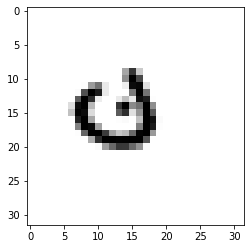

In [8]:
plt.imshow(next(train_gen)[0][1][:,:,1],'binary')

# Create test data generator

In [9]:
test_dir = os.path.join(DATA_DIR, 'test/')

test_ds = image_dataset_from_directory(test_dir,
                                       image_size=(32, 32),
                                       batch_size=30,
                                       shuffle=False,
                                       label_mode=None)

Found 3360 files belonging to 1 classes.


# Building model structure

In [10]:
def get_CNN_model():
    input = Input(shape=(32,32,3))
    
    block1 = Conv2D(32, (5,5), padding="same", activation="relu")(input)
    block1 = Conv2D(32, (5,5), padding="same", activation="relu")(block1)
    block1 = Conv2D(32, (5,5), padding="same", activation="relu")(block1)
    block1 = MaxPooling2D((2,2))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Dropout(0.25)(block1)
    
    block2 = Conv2D(64, (3,3), padding="same", activation="relu")(block1)
    block2 = Conv2D(64, (3,3), padding="same", activation="relu")(block2)
    block2 = Conv2D(64, (3,3), padding="same", activation="relu")(block2)
    block2 = MaxPooling2D((2,2))(block2)
    block2 = BatchNormalization()(block2)
    block2 = Dropout(0.25)(block2)
    
    dense = Flatten()(block2)
    dense = Dense(256, activation="relu")(dense)
    dense = Dense(128, activation="relu")(dense)
    dense = Dropout(0.4)(dense)
    
    output = Dense(28, activation="softmax")(dense)
    
    model = Model(input, output)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [11]:
model = get_CNN_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                               

### Model Callbacks

In [12]:
checkpoint_cb = ModelCheckpoint(filepath=os.path.join(DATA_DIR, 'models/model.h5'), save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_cb = EarlyStopping(patience=50, restore_best_weights=True)

### Model training

In [13]:
history = model.fit(train_gen,
                    epochs = 100,
                    steps_per_epoch = train_gen.samples // BATCH_SIZE,
                    validation_data = val_gen,
                    validation_steps = val_gen.samples // BATCH_SIZE,
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
336/336 [==============================] - ETA: 0s - loss: 2.3554 - accuracy: 0.2889
Epoch 00001: val_accuracy improved from -inf to 0.12612, saving model to models\model.h5
336/336 [==============================] - 150s 442ms/step - loss: 2.3554 - accuracy: 0.2889 - val_loss: 4.1459 - val_accuracy: 0.1261
Epoch 2/100
336/336 [==============================] - ETA: 0s - loss: 1.2288 - accuracy: 0.5794
Epoch 00002: val_accuracy improved from 0.12612 to 0.62723, saving model to models\model.h5
336/336 [==============================] - 113s 337ms/step - loss: 1.2288 - accuracy: 0.5794 - val_loss: 1.1612 - val_accuracy: 0.6272
Epoch 3/100
336/336 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.7215
Epoch 00003: val_accuracy did not improve from 0.62723
336/336 [==============================] - 110s 328ms/step - loss: 0.8273 - accuracy: 0.7215 - val_loss: 1.2787 - val_accuracy: 0.5859
Epoch 4/100
336/336 [==============================] - ETA: 0s - los

Epoch 28/100
336/336 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9764
Epoch 00028: val_accuracy improved from 0.94903 to 0.95312, saving model to models\model.h5
336/336 [==============================] - 118s 351ms/step - loss: 0.0766 - accuracy: 0.9764 - val_loss: 0.2721 - val_accuracy: 0.9531
Epoch 29/100
336/336 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9813
Epoch 00029: val_accuracy did not improve from 0.95312
336/336 [==============================] - 118s 351ms/step - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.2559 - val_accuracy: 0.9368
Epoch 30/100
336/336 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9802
Epoch 00030: val_accuracy did not improve from 0.95312
336/336 [==============================] - 117s 349ms/step - loss: 0.0669 - accuracy: 0.9802 - val_loss: 0.3107 - val_accuracy: 0.9338
Epoch 31/100
336/336 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9766
E

Epoch 56/100
336/336 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9900
Epoch 00056: val_accuracy did not improve from 0.96317
336/336 [==============================] - 106s 316ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 0.2691 - val_accuracy: 0.9520
Epoch 57/100
336/336 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9893
Epoch 00057: val_accuracy did not improve from 0.96317
336/336 [==============================] - 106s 315ms/step - loss: 0.0384 - accuracy: 0.9893 - val_loss: 0.2631 - val_accuracy: 0.9617
Epoch 58/100
336/336 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9870
Epoch 00058: val_accuracy did not improve from 0.96317
336/336 [==============================] - 107s 319ms/step - loss: 0.0463 - accuracy: 0.9870 - val_loss: 0.2908 - val_accuracy: 0.9505
Epoch 59/100
336/336 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9880
Epoch 00059: val_accuracy did not impr

336/336 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9934
Epoch 00084: val_accuracy did not improve from 0.96949
336/336 [==============================] - 129s 383ms/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.3836 - val_accuracy: 0.9639
Epoch 85/100
336/336 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9923
Epoch 00085: val_accuracy did not improve from 0.96949
336/336 [==============================] - 115s 343ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.3106 - val_accuracy: 0.9688
Epoch 86/100
336/336 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9910
Epoch 00086: val_accuracy did not improve from 0.96949
336/336 [==============================] - 111s 330ms/step - loss: 0.0438 - accuracy: 0.9910 - val_loss: 0.4378 - val_accuracy: 0.9505
Epoch 87/100
336/336 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9920
Epoch 00087: val_accuracy improved from 0.96949 to 

# 

# 

# Model Testing

In [16]:
my_model = load_model("models/model.h5")

In [17]:
all_test_data_predictions = my_model.predict(test_ds)

Prediction is : ه


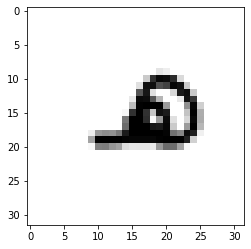

Prediction is : ر


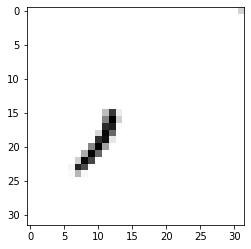

Prediction is : أ


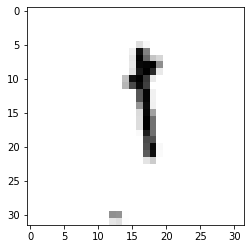

Prediction is : ر


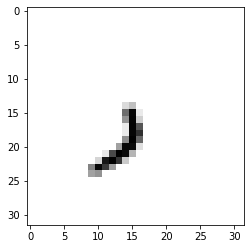

Prediction is : ض


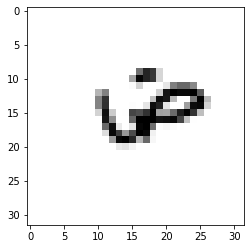

Prediction is : ص


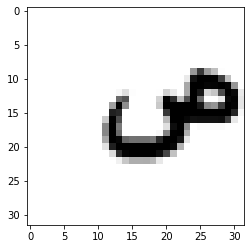

Prediction is : ل


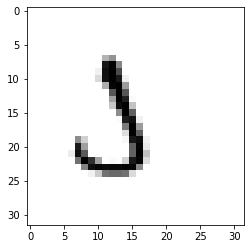

Prediction is : ر


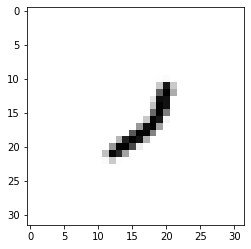

Prediction is : و


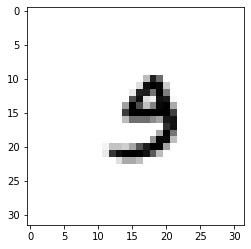

Prediction is : ع


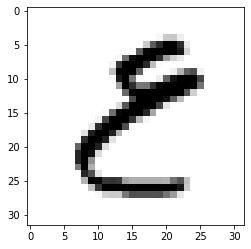

Prediction is : ع


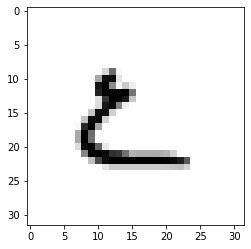

Prediction is : ظ


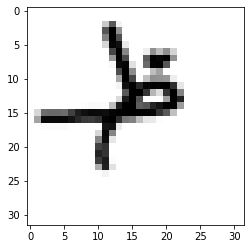

Prediction is : ه


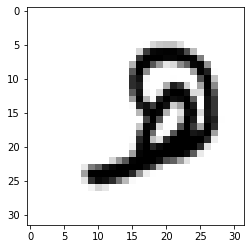

Prediction is : ص


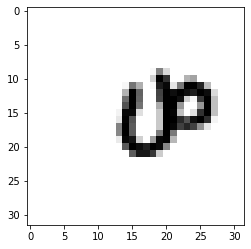

Prediction is : أ


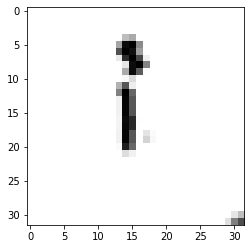

Prediction is : ذ


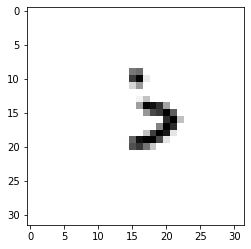

Prediction is : ز


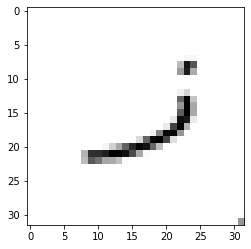

Prediction is : ن


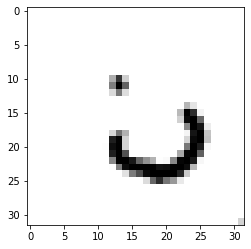

Prediction is : ص


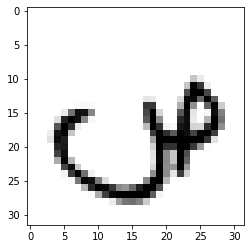

Prediction is : ر


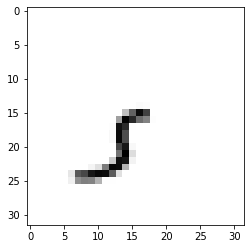

Prediction is : ذ


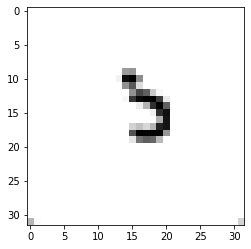

Prediction is : ذ


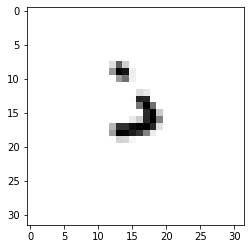

Prediction is : ه


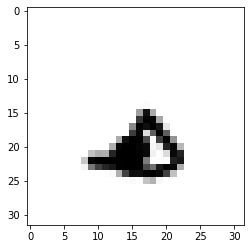

Prediction is : س


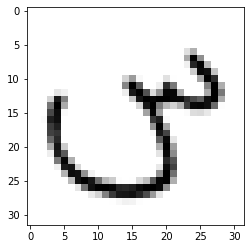

Prediction is : ف


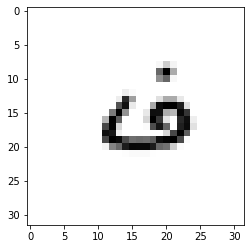

Prediction is : ع


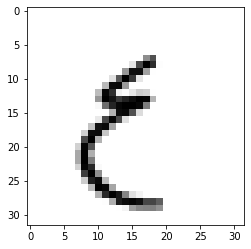

Prediction is : خ


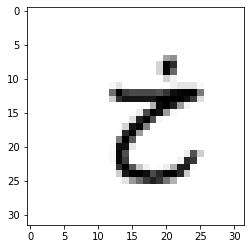

Prediction is : ث


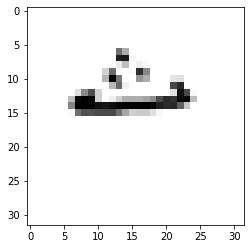

Prediction is : ش


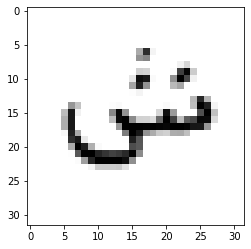

Prediction is : س


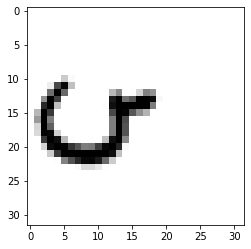

In [30]:
for index in range(next(test_ds.as_numpy_iterator()).shape[0]) :
    print("Prediction is : " + arabic_characters[np.argmax(all_test_data_predictions[index])])
    plt.imshow(next(test_ds.as_numpy_iterator())[index][:,:,1],'binary')
    plt.show()
    print("================================")